In [6]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

2023-03-06 21:20:06.497929: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


In [9]:
voices =  os.path.join('tracks','voices')
wake =  os.path.join('tracks','wake_up')

In [12]:
wake

'tracks/wake_up'

In [13]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [126]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [42]:
wave = load_mp3_16k_mono('/home/bekzhan/DSD-project/DSD-Project/tracks/voices/common_voice_en_34925857.mp3')


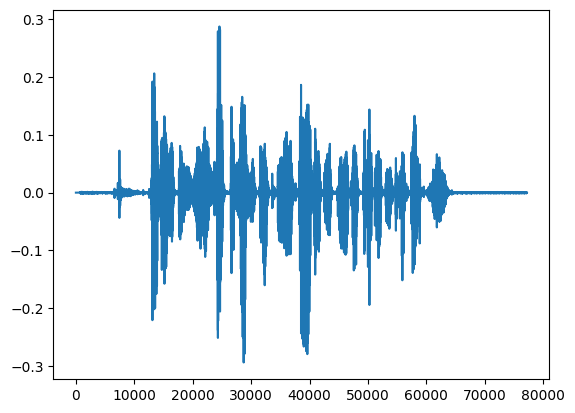

In [43]:
plt.plot(wave)
plt.show()


In [125]:
POS=os.path.join('tracks','wake')
NEG=os.path.join('tracks','voices') 

In [127]:
pos = tf.data.Dataset.list_files(POS+'/*.mp3')
neg = tf.data.Dataset.list_files(NEG+'/*.mp3')

In [128]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [79]:
lengths = []
for file in os.listdir(os.path.join('tracks','voices')):
    tensor_wave = load_mp3_16k_mono(os.path.join('tracks','voices', file))
    lengths.append(len(tensor_wave))

In [80]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=82113>

In [81]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=25920>

In [82]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=168768>

In [174]:
def preprocess(file_path, label): 
    wav = load_mp3_16k_mono(file_path)
    print(1)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [167]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [169]:
spectrogram, label = preprocess(filepath, label)

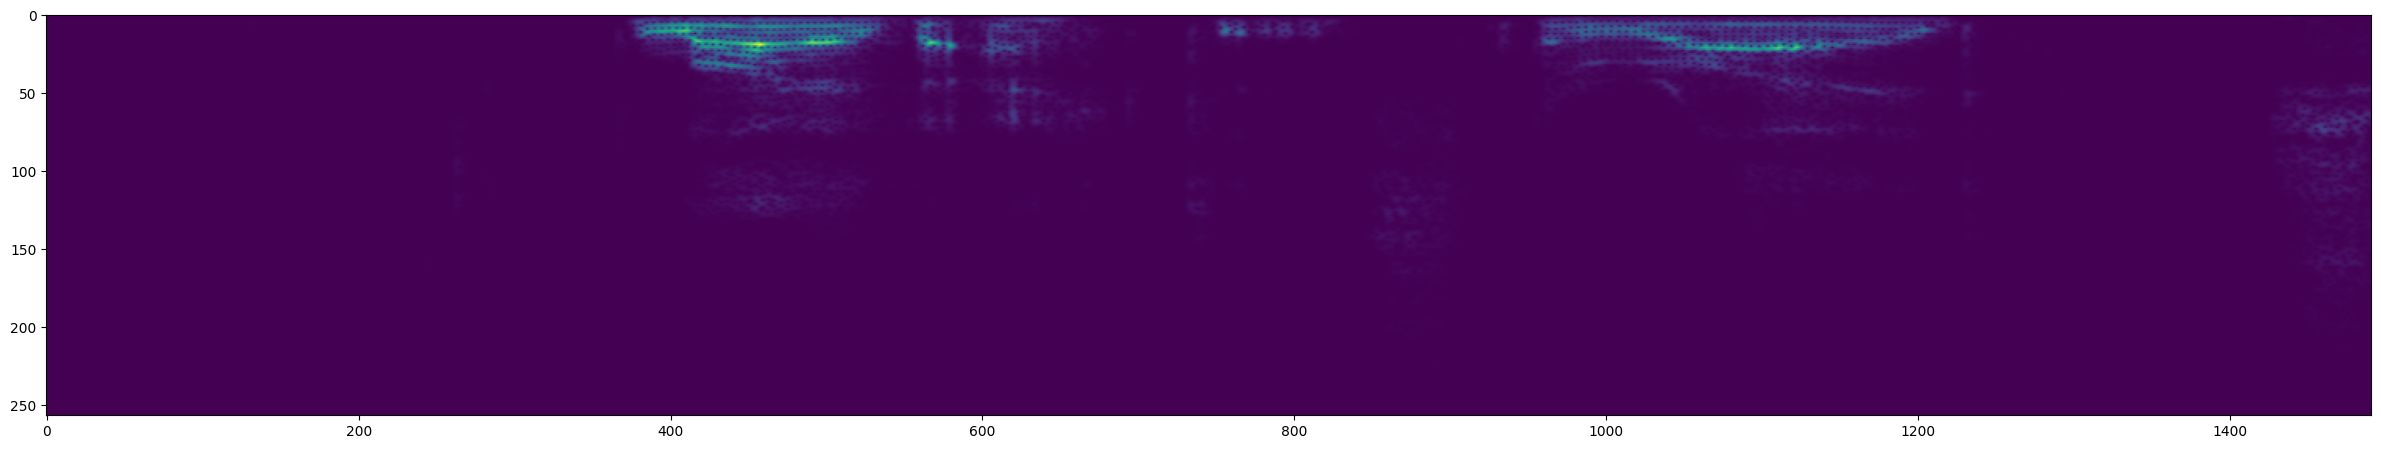

In [170]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [176]:
data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

AssertionError: in user code:

    /tmp/ipykernel_20522/4138653990.py:2 preprocess  *
        wav = load_mp3_16k_mono(file_path)
    /tmp/ipykernel_20522/2639244269.py:3 load_mp3_16k_mono  *
        res = tfio.audio.AudioIOTensor(filename)
    /home/bekzhan/.local/lib/python3.8/site-packages/tensorflow_io/core/python/ops/audio_ops.py:235 __init__  **
        assert dtype is not None, "dtype must be provided in graph mode"

    AssertionError: dtype must be provided in graph mode


In [156]:
train = data.take(35)
test = data.skip(35).take(15)

In [162]:
samples, labels = train.as_numpy_iterator().next()

In [163]:
samples.shape

(16,)